# CapyMOA Exercises

This notebook contains the solutions to the exercises.  

---

### CapyMOA 

* More information about CapyMOA can be found in: [https://github.com/adaptive-machine-learning/CapyMOA](https://github.com/adaptive-machine-learning/CapyMOA)

* _If you find CapyMOA useful, considering starring the project and joining the Discord channel!_

* **More tutorials are available at the [CapyMOA tutorials page](https://capymoa.org/tutorials.html)**

**Code examples are based on CapyMOA v0.7.0 as of 04/10/2024**

# 1. Exercises (Basic classification)

## 1.1 Improve predictive performance.

Using `RTG_2abrupt` stream try to improve the predictive performance of the Hoeffding Tree algorithm by changing its hyperparameters (See the Hoeffding Tree's [API reference](https://capymoa.org/api/modules/capymoa.classifier.HoeffdingTree.html)). 


**More details/Tips**
* The synthetic stream snapshot `RTG_2abrupt` includes 100,000 instances. 
* To plot the same learner under different names, you can override the `learner` attribute in the results from `prequential_evaluation` as shown in the sample code below.

Cumulative Accuracy: 57.677


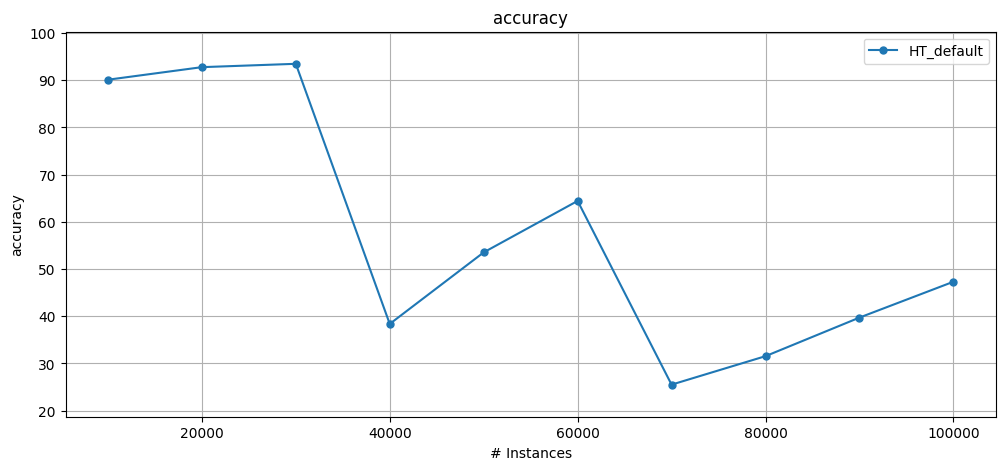

In [1]:
from capymoa.datasets import RTG_2abrupt
from capymoa.classifier import HoeffdingTree
from capymoa.evaluation import prequential_evaluation
from capymoa.evaluation.visualization import plot_windowed_results


rtg2_stream = RTG_2abrupt()
ht_default = HoeffdingTree(schema=rtg2_stream.get_schema())
# Tip: Add other variations of HT

results = prequential_evaluation(stream=rtg2_stream, learner=ht_default, window_size=10000)
results.learner = 'HT_default'

# Tip: Add the evaluation for other HTs

print(f'Cumulative Accuracy: {results.cumulative.accuracy()}')
plot_windowed_results(results, metric='accuracy', save_only=False)    

In [2]:
# These were the values tested to find hyperparameters with better performance
grace_period_options = [50, 100, 200, 300, 400, 500]
print("grace_period_options:", grace_period_options)

confidence_options = [0.0005,0.001, 0.005, 0.01, 0.05, 0.1]
print("confidence_options:", confidence_options)

leaf_prediction_options = ["MajorityClass", "NaiveBayes", "NaiveBayesAdaptive"]
print("leaf_prediction_options:", leaf_prediction_options)

grace_period_options: [50, 100, 200, 300, 400, 500]
confidence_options: [0.0005, 0.001, 0.005, 0.01, 0.05, 0.1]
leaf_prediction_options: ['MajorityClass', 'NaiveBayes', 'NaiveBayesAdaptive']


In [3]:
def generate_results(ht_configs, results_list, max_cumulative_accuracy):
    # Initialize the stream and learner
    rtg2_stream = RTG_2abrupt()
    ht = HoeffdingTree(schema=rtg2_stream.get_schema(), **ht_configs)

    # Perform the evaluation
    results = prequential_evaluation(stream=rtg2_stream, learner=ht, window_size=10000)
    
    # Save the learner's name
    results.learner = "-".join([f"{value}" for key, value in ht_configs.items()])

    # Print the current cumulative accuracy
    print(f"Cumulative Accuracy for {results.learner}: {results.cumulative.accuracy()}")

    # Check if we have a new maximum accuracy
    if max_cumulative_accuracy["curr_max"] < results.cumulative.accuracy():

        # Update max accuracy details       
        max_cumulative_accuracy["curr_max"] = results.cumulative.accuracy()
        max_cumulative_accuracy["params"] = ht_configs.copy()
        max_cumulative_accuracy["index"] = len(results_list)-1
    
    results_list.append(results)
    return results_list, max_cumulative_accuracy

In [4]:
ht_configs = {
    "grace_period": 200,
    "confidence": 1e-3,
    "leaf_prediction": 'NaiveBayesAdaptive'
}

results_list = []
max_cumulative_accuracy = {"curr_max": 0, "params": None}

for grace_period_option in grace_period_options:
    for confidence_option in confidence_options:
        for leaf_prediction_option in leaf_prediction_options:
            ht_configs["grace_period"] = grace_period_option
            ht_configs["confidence"] = confidence_option
            ht_configs["leaf_prediction"] = leaf_prediction_option
            results_list, max_cumulative_accuracy = generate_results(
                ht_configs, results_list, max_cumulative_accuracy)
            print(max_cumulative_accuracy)

Cumulative Accuracy for 50-0.0005-MajorityClass: 52.17
{'curr_max': 52.17, 'params': {'grace_period': 50, 'confidence': 0.0005, 'leaf_prediction': 'MajorityClass'}, 'index': -1}
Cumulative Accuracy for 50-0.0005-NaiveBayes: 57.346
{'curr_max': 57.346, 'params': {'grace_period': 50, 'confidence': 0.0005, 'leaf_prediction': 'NaiveBayes'}, 'index': 0}
Cumulative Accuracy for 50-0.0005-NaiveBayesAdaptive: 57.257000000000005
{'curr_max': 57.346, 'params': {'grace_period': 50, 'confidence': 0.0005, 'leaf_prediction': 'NaiveBayes'}, 'index': 0}
Cumulative Accuracy for 50-0.001-MajorityClass: 51.977
{'curr_max': 57.346, 'params': {'grace_period': 50, 'confidence': 0.0005, 'leaf_prediction': 'NaiveBayes'}, 'index': 0}
Cumulative Accuracy for 50-0.001-NaiveBayes: 58.097
{'curr_max': 58.097, 'params': {'grace_period': 50, 'confidence': 0.001, 'leaf_prediction': 'NaiveBayes'}, 'index': 3}
Cumulative Accuracy for 50-0.001-NaiveBayesAdaptive: 57.994
{'curr_max': 58.097, 'params': {'grace_period': 50

The best combination of hyperparameters found were {'grace_period': 200, 'confidence': 0.05, 'leaf_prediction': 'NaiveBayes'}
The accuracy obtained was : 64.082 %


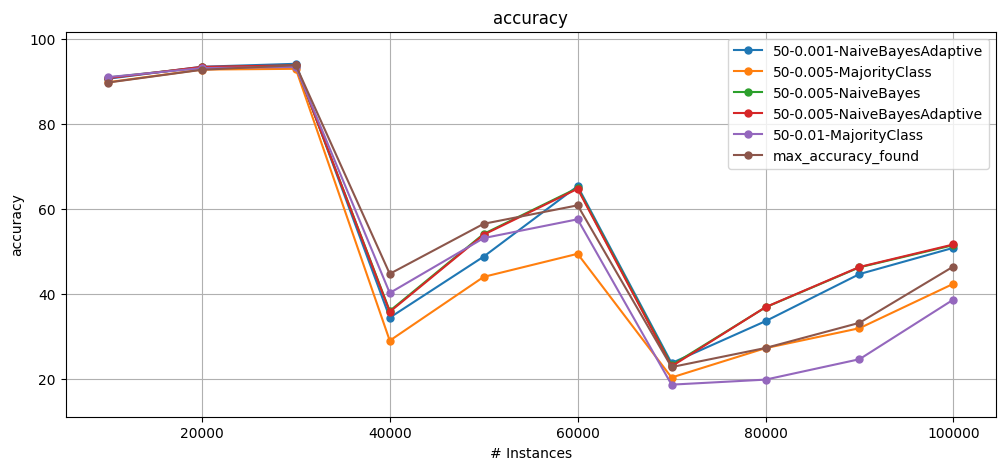

In [5]:
print(f'The best combination of hyperparameters found were {max_cumulative_accuracy["params"]}')
print(f'The accuracy obtained was : {max_cumulative_accuracy["curr_max"]} %')

# Plot some results for comparison
results_list[max_cumulative_accuracy["index"]].learner = "max_accuracy_found"
plot_windowed_results(*results_list[5:10],results_list[max_cumulative_accuracy["index"]], metric='accuracy', save_only=False)

## 1.2 Assessing results using different metrics and approaches

### 1.2.1 Assess the results for the experiments below using the `Electricity` stream below using different metrics. You may also want to verify the windowed versions of the metrics (either in a plot or on a list/dataframe). 

**Answer**: 

When evaluating the performance of different learners on the **Electricity** stream using metrics such as **Accuracy**, **Precision**, and **Recall**, the following can be observed:

- **Naive Bayes** consistently performs worse across all three metrics. Its accuracy remains low throughout the evaluation, and it struggles significantly with classifying instances correctly, which is reflected in its lower precision and recall values. This suggests that Naive Bayes is not well-suited to this dataset.

- **NoChange Classifier** (a simple baseline model) shows consistent performance, but its results are relatively poor in terms of accuracy and precision, as expected. Since this model predicts the majority class, it can occasionally have high recall, but it lacks the adaptability to handle the complexity of the data.

- **Adaptive Random Forest (ARF)** demonstrates fluctuating performance across the metrics. Although it initially shows inconsistency, ARF adapts to the data over time, and its accuracy, precision, and recall eventually surpass those of the other models. This fluctuation is typical in streaming environments, where the data distribution may change, but ARF's ability to adapt gives it an advantage in the long run. By the end of the stream, ARF outperforms the other classifiers in terms of overall predictive power.

### 1.2.2 What can be observed when comparing the results from a complex model such as ARF and the NoChange classifier using a metric like `kappa_t`? 

**Answer:** 

**Results Overview**

- **NoChange Classifier**: The Kappa_t for this model remains constant at 0, indicating that its predictions are equivalent to random guessing throughout the entire evaluation.
- **Naive Bayes Classifier**: This model starts with a Kappa_t of -25 and ends at -45. This suggests that Naive Bayes struggles significantly with the data, performing worse than random guessing for most of the stream.
- **Adaptive Random Forest Classifier**: The Kappa_t begins at -3 but improves over time, finishing at 10. This shows that ARF starts poorly but eventually outperforms random guessing and achieves a positive performance as it adapts to the data.

**Comparing ARF and NoChange Classifier using Kappa_t:** When comparing the results of the complex **Adaptive Random Forest** (ARF) and the simpler **NoChange** classifier, we observe that while the NoChange model maintains a constant performance equivalent to random guessing (Kappa_t = 0), the ARF demonstrates improvement over time. Initially, ARF performs poorly, but as it adapts to the data stream and eventually provides meaningful predictions (Kappa_t > 0). 


**More details/Tips**
* You can use the `cumulative` and `windowed` objects to access the metrics associated with a particular result from `prequential_evaluation`
* The available metrics are accessible through `metrics_header()` as shown in the example below

In [6]:
from capymoa.evaluation import prequential_evaluation
from capymoa.datasets import Electricity
from capymoa.classifier import NaiveBayes, NoChange, AdaptiveRandomForestClassifier

elec_stream = Electricity()

naive_bayes = NaiveBayes(schema=elec_stream.get_schema())
no_change = NoChange(schema=elec_stream.get_schema())
arf = AdaptiveRandomForestClassifier(schema=elec_stream.get_schema(), number_of_jobs=4)

results_naive_bayes = prequential_evaluation(stream=elec_stream, learner=naive_bayes, window_size=4500)
results_no_change = prequential_evaluation(stream=elec_stream, learner=no_change, window_size=4500)
results_arf = prequential_evaluation(stream=elec_stream, learner=arf, window_size=4500)

# The available metrics:
results_naive_bayes.metrics_header()

['instances',
 'accuracy',
 'kappa',
 'kappa_t',
 'kappa_m',
 'f1_score',
 'f1_score_0',
 'f1_score_1',
 'precision',
 'precision_0',
 'precision_1',
 'recall',
 'recall_0',
 'recall_1']

[Cumulative] Naive Bayes Accuracy: 73.36246468926554
[Windowed] Naive Bayes Accuracy: [80.11111111111111, 78.22222222222223, 77.08888888888889, 74.71111111111111, 70.44444444444444, 69.02222222222221, 63.77777777777778, 64.08888888888889, 78.26666666666667, 77.57777777777778, 78.35555555555555]
[Cumulative] No Change Accuracy: 85.33059675141243
[Windowed] No Change Accuracy: [83.86666666666667, 83.22222222222221, 85.31111111111112, 85.6, 84.04444444444444, 87.28888888888889, 87.82222222222222, 86.77777777777777, 85.17777777777778, 84.44444444444444, 84.6888888888889]
[Cumulative] ARF Accuracy: 82.67125706214689
[Windowed] ARF Accuracy: [82.02222222222221, 84.35555555555555, 83.82222222222222, 84.35555555555555, 84.77777777777777, 81.28888888888889, 79.73333333333333, 77.3111111111111, 81.33333333333333, 87.04444444444445, 87.24444444444444]


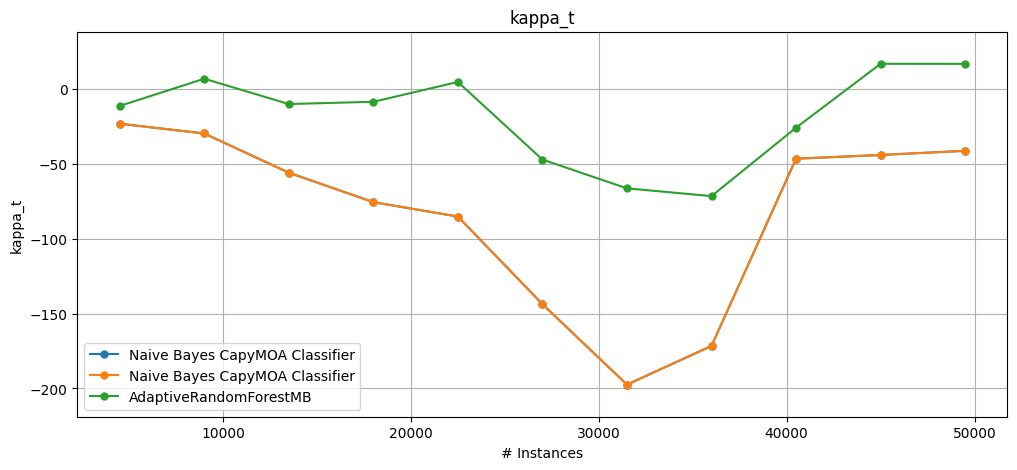

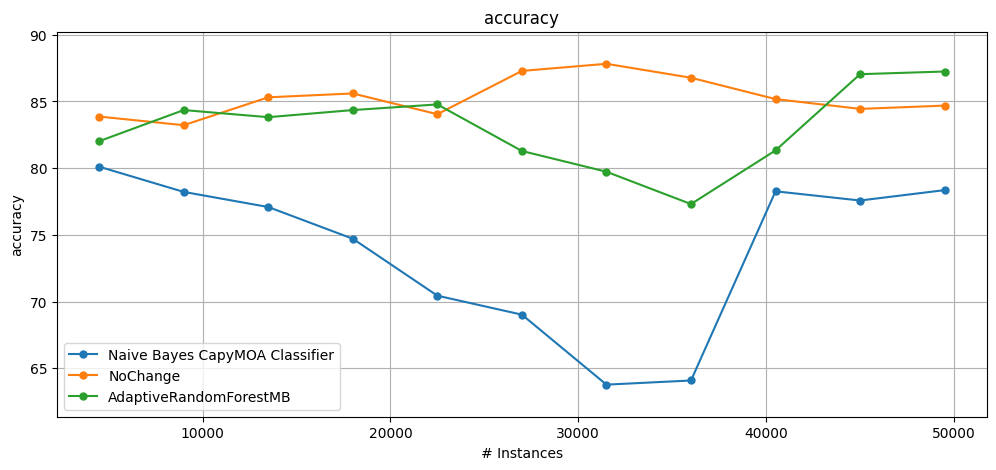

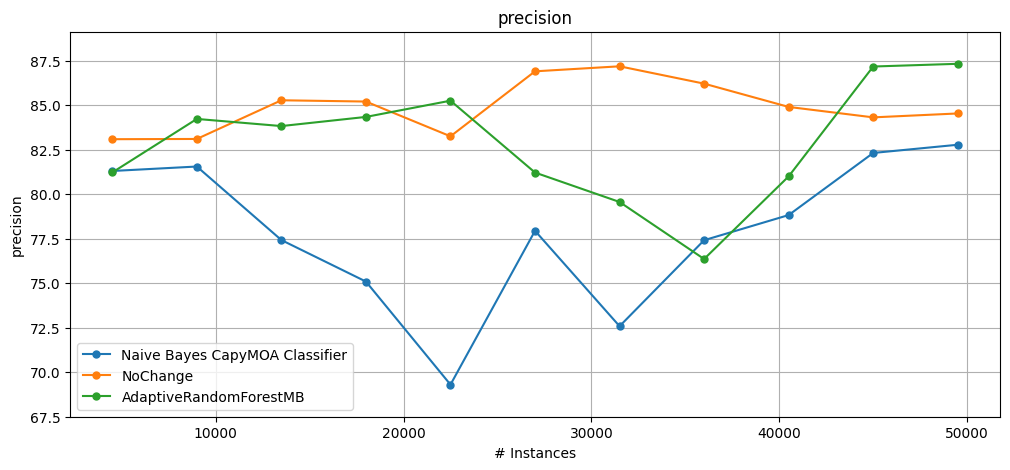

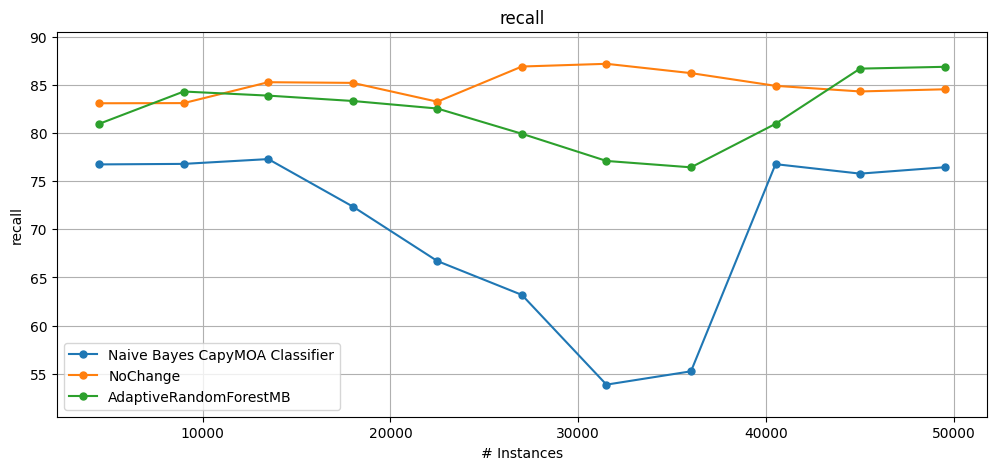

In [7]:
from capymoa.evaluation.visualization import plot_windowed_results

# Naive Bayes
print(f'[Cumulative] Naive Bayes Accuracy: {results_naive_bayes.cumulative.accuracy()}')
print(f'[Windowed] Naive Bayes Accuracy: {results_naive_bayes.windowed.accuracy()}')

# No Change
print(f'[Cumulative] No Change Accuracy: {results_no_change.cumulative.accuracy()}')
print(f'[Windowed] No Change Accuracy: {results_no_change.windowed.accuracy()}')

# ARF
print(f'[Cumulative] ARF Accuracy: {results_arf.cumulative.accuracy()}')
print(f'[Windowed] ARF Accuracy: {results_arf.windowed.accuracy()}')

plot_windowed_results(results_naive_bayes,results_naive_bayes,results_arf,metric='kappa_t')
plot_windowed_results(results_naive_bayes,results_no_change,results_arf,metric='accuracy')
plot_windowed_results(results_naive_bayes,results_no_change,results_arf,metric='precision')
plot_windowed_results(results_naive_bayes,results_no_change,results_arf,metric='recall')

# 2. Exercises (Drift)

## 2.1 Detect drifts based on a classifier output

Given the following synthetic stream with 1 abrupt concept drift, use SEED [Huang et al, 2014] to observe whether a drift has occurred based on the learner output, i.e. the correct and incorrect predictions. 


**More details/Tips**
* The sample code below shows how we can define the stream and visualize it if we are using a high-level evaluation function such as `prequential_evaluation`
* To solve this exercise you will need to access each of the individual predictions by the learner, so we can't use `prequential_evaluation` and will use instead a `while loop`


**References**
```
Huang, David Tse Jung, et al. "Detecting volatility shift in data streams."
2014 IEEE International Conference on Data Mining. IEEE, 2014.
```

Cumulative accuracy: 63.56


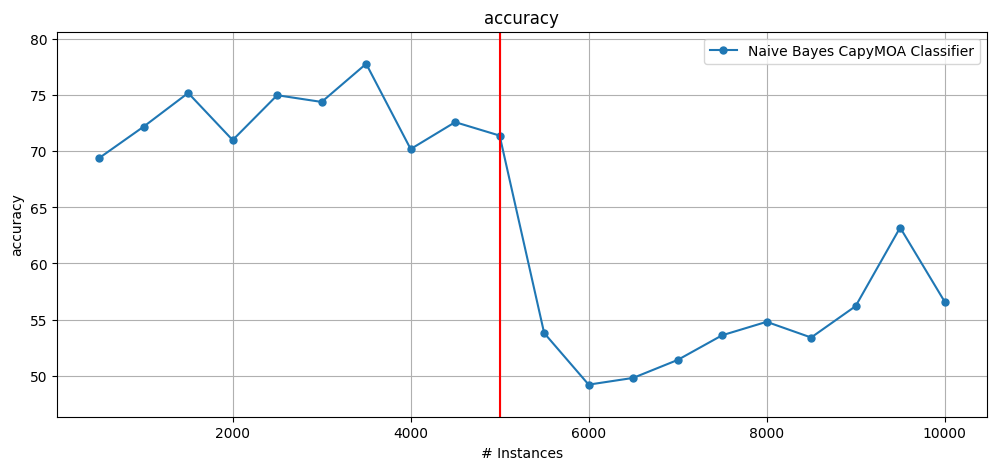

In [8]:
# You don't need to modify the code in this cell
from capymoa.stream.drift import DriftStream, Drift, AbruptDrift, GradualDrift
from capymoa.stream.generator import RandomTreeGenerator
from capymoa.classifier import NaiveBayes
from capymoa.evaluation.visualization import plot_windowed_results
from capymoa.drift.detectors import ADWIN


stream_sea1drift = DriftStream(stream=[RandomTreeGenerator(tree_random_seed=1), 
                                AbruptDrift(position=5000), 
                                RandomTreeGenerator(tree_random_seed=2)])

nb = NaiveBayes(schema=stream_sea1drift.get_schema())

results_nb = prequential_evaluation(stream=stream_sea1drift, learner=nb, window_size=500, max_instances=10000)

print(f'Cumulative accuracy: {results_nb.cumulative.accuracy()}')
plot_windowed_results(results_nb, metric='accuracy')

In [9]:
## Sample code

from capymoa.stream.drift import DriftStream, Drift, AbruptDrift, GradualDrift
from capymoa.stream.generator import RandomTreeGenerator
from capymoa.classifier import NaiveBayes
from capymoa.evaluation.visualization import plot_windowed_results
from capymoa.drift.detectors import SEED

from capymoa.evaluation import ClassificationEvaluator


stream_sea1drift = DriftStream(stream=[RandomTreeGenerator(tree_random_seed=1), 
                                AbruptDrift(position=5000), 
                                RandomTreeGenerator(tree_random_seed=2)])

evaluator = ClassificationEvaluator(schema=stream_sea1drift.get_schema())

nb = NaiveBayes(schema=stream_sea1drift.get_schema())

detector = SEED(delta=0.05) # 0.05 is the default value (smaller values = higher confidence on the change)

i = 0
max_instances = 10000
while stream_sea1drift.has_more_instances() and i < max_instances:
    instance = stream_sea1drift.next_instance()
    pred = nb.predict(instance)
    evaluator.update(instance.y_index, pred)    

    # <what should we keep track? In other words, what is the input to the drift detector? The correct and incorrect predictions>

    correct_prediction = (pred == instance.y_index)
    detector.add_element(correct_prediction)

    # <how do we check if a drift has happened after updating the detector?>
    # Check if a drift has been detected
    if detector.detected_change():
        print('Change detected at instance: ' + str(i))    
    
    nb.train(instance)
    i += 1
print(evaluator.accuracy())

# How many drifts were detected? 
print(f'Number of drifts detected: {len(detector.detection_index)}')

Change detected at instance: 5087
Change detected at instance: 9183
63.56
Number of drifts detected: 2


# 3. Exercises (Ensemble and Adaptive learning)

## 3.1 Implement a heterogeneous ensemble learner

Based on the sample code below, complete the implementation of the ensemble. This is a heterogeneous ensemble where the members may be any learner. 
This exercise looks like a lot, but in fact you just need to implement the training method. 

**More details/Tips**
* This exercise is based on a tutorial that shows how to create a new learner in capymoa (Available [here](https://capymoa.org/notebooks/05_new_learner.html)).


In [10]:
from capymoa.base import Classifier
from capymoa.classifier import HoeffdingTree, NaiveBayes, HoeffdingAdaptiveTree

from collections import Counter
import numpy as np
import random
import math


# Must inherit from Classifier
class HeterogeneousEnsemble(Classifier):
    def __init__(self, schema=None, random_seed=1, base_learners_classes=[HoeffdingTree, NaiveBayes, HoeffdingAdaptiveTree]):
        super().__init__(schema=schema, random_seed=random_seed)

        self.ensemble_size = len(base_learners_classes)
        self.ensemble = []
        for i in range(self.ensemble_size):
            self.ensemble.append(base_learners_classes[0](schema=self.schema, random_seed=random_seed))

    def __str__(self):
        return 'HeterogeneousEnsemble'

    # You must 
    def train(self, instance):
        for i in range(self.ensemble_size):
            self.ensemble[i].train(instance)

    # predict is already implemented...
    def predict(self, instance):
        predictions = []
        for i in range(self.ensemble_size):
            predictions.append(self.ensemble[i].predict(instance))
        majority_vote = Counter(predictions)
        prediction = majority_vote.most_common(1)[0][0]
        return prediction

    # For this exercise we don't need to implement predict_proba
    def predict_proba(self, instance):
        pass

HeterogeneousEnsemble(HT, NB, HAT) accuracy: 81.72669491525424, wallclock: 5.431691408157349
HeterogeneousEnsemble(KNN, EFDT, SGD) accuracy: 84.08147951977402, wallclock: 31.942774534225464


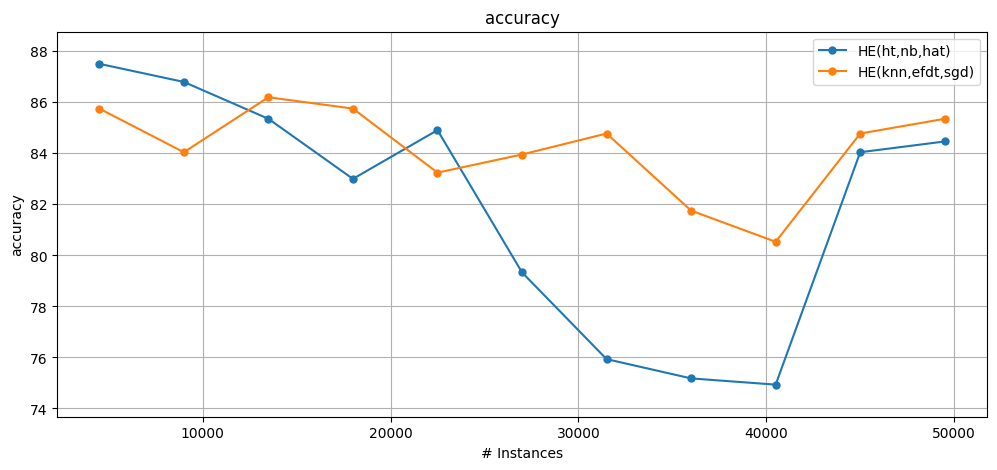

In [11]:
# Code to test the ensemble, you don't need to modify this code

from capymoa.evaluation import prequential_evaluation
from capymoa.evaluation.visualization import plot_windowed_results
from capymoa.datasets import Electricity
from capymoa.classifier import HoeffdingTree, EFDT, NaiveBayes, KNN, HoeffdingAdaptiveTree, SGDClassifier

elec_stream = Electricity()

# Creating a learner: using a hoeffding adaptive tree as the base learner
ht_nb_hat = HeterogeneousEnsemble(schema=elec_stream.get_schema(), 
                                  base_learners_classes=[HoeffdingTree, NaiveBayes, HoeffdingAdaptiveTree])
knn_efdt_sgd = HeterogeneousEnsemble(schema=elec_stream.get_schema(),
                                   base_learners_classes=[KNN, EFDT, SGDClassifier])

results_ht_nb_hat = prequential_evaluation(stream=elec_stream, learner=ht_nb_hat, window_size=4500)
print(f"HeterogeneousEnsemble(HT, NB, HAT) accuracy: {results_ht_nb_hat.cumulative.accuracy()}, wallclock: {results_ht_nb_hat.wallclock()}")
results_knn_efdt_sgd = prequential_evaluation(stream=elec_stream, learner=knn_efdt_sgd, window_size=4500)
print(f"HeterogeneousEnsemble(KNN, EFDT, SGD) accuracy: {results_knn_efdt_sgd.cumulative.accuracy()}, wallclock: {results_knn_efdt_sgd.wallclock()}")

results_ht_nb_hat.learner = "HE(ht,nb,hat)"
results_knn_efdt_sgd.learner = "HE(knn,efdt,sgd)"
plot_windowed_results(results_ht_nb_hat, results_knn_efdt_sgd, metric="accuracy")

## 3.2 Simple Adaptive Learning

The goal is to create a drift detection aware learner. The following classifier should be capable of detecting drifts based on the output of its base classifier (correct and incorrect predictions) and then reset the model whenever a drift is detected. You should try to improve the performance by implementing a heuristic that avoid resets if they are not at least `min_reset_window` apart. To further improve the overall predictive performance you can also modify the drift detector hyperparameters.

This can be easily achieved by modifying the training and resetting logic a little bit. 



In [12]:
from capymoa.drift.detectors import ADWIN, SEED
from capymoa.classifier import HoeffdingTree
from capymoa.base import Classifier

class DriftDetectionClassifier(Classifier):
    def __init__(self, classifier, drift_detector, min_reset_window=100):
        # delegating schema and random_seed to be set by the super class 'Classifier' 
        super().__init__(schema=classifier.schema, random_seed=classifier.random_seed)

        self.classifier = classifier
        # sets the drift detector
        self.drift_detector = drift_detector
        # save the args in case we need to reset the classifier later
        self.classifier_args = self._get_init_args(classifier)

        self.instances_since_last_reset = 0

        self.min_reset_window = min_reset_window
        
        # Simple counter so that you can make sense of the detections
        self.instances_seen = 0
        
    def __str__(self):
        return 'DriftDetectionClassifier'

    def train(self, instance):
        self.instances_since_last_reset += 1
        
        self.instances_seen += 1        

        pred = self.classifier.predict(instance)
        y = instance.y_index
        # Monitor the correct/incorrect predictions from self.classifier
        # then update the drift detector self.drift_detector using the 
        # correct (1) or incorrect predictions (0), finally check if a 
        # change has been detected after every update. 
        self.drift_detector.add_element(pred == instance.y_index)
       
        # Has a drift been detected? If yes, then we should invoke self.reset 
        # Also, depending on the detector, sometimes immediately after a drift 
        # another drift may be triggered, we can add a heuristic to avoid that 
        # based on the self.instances_since_last_reset, so we might want to keep 
        # it updated and take it into account when deciding if the reset should 
        # take place. 
        
        if self.drift_detector.detected_change() and self.instances_since_last_reset >= self.min_reset_window:
            self.instances_since_last_reset = 0
            print(f'Change detected at instance: {self.instances_seen}')
            self.reset()

        self.classifier.train(instance)

    def reset(self, schema=None):
        # obtain the class of the classifier and create a new one using the arguments saved before
        # print(type(**self.classifier_args))

        if schema is not None:
            self.classifier_args['schema'] = schema
        # print (self.classifier_args)
        self.classifier = self.classifier.__class__(schema=self.schema)
        
        self.classifier.__class__(**self.classifier_args)

    def predict(self, instance):
        return self.classifier.predict(instance)

    def predict_proba(self, instance):
        return self.classifier.predict_proba(instance)

    def _get_init_args(self, obj):
        # filter only the arguments needed for initialization
        init_args = {}
        for param in obj.__init__.__code__.co_varnames:
            if param in obj.__dict__:
                init_args[param] = obj.__dict__[param]
        return init_args

### 3.2.1 Testing the DriftDetectionClassifier

Change detected at instance: 10944
cumulative accuracy HT: 75.38 and DDC: 76.84666666666666


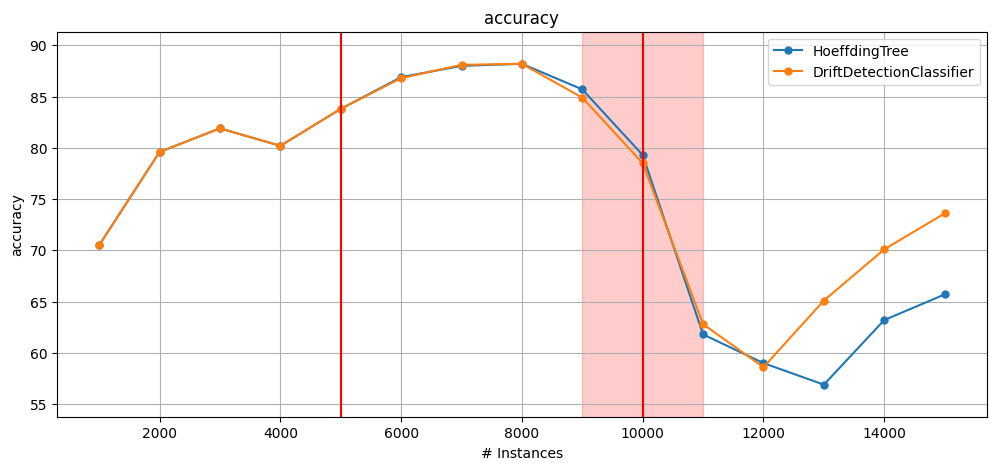

In [13]:
## Testing the DriftDetectionClassifier, you might want to experiment with the min_reset_window hyperparameter after updating the learner

from capymoa.stream.drift import DriftStream, Drift, AbruptDrift, GradualDrift
from capymoa.stream.generator import RandomTreeGenerator
from capymoa.evaluation import prequential_evaluation
from capymoa.evaluation.visualization import plot_windowed_results
from capymoa.classifier import HoeffdingTree

stream_sea2drift = DriftStream(stream=[RandomTreeGenerator(tree_random_seed=1), 
                                AbruptDrift(position=5000), 
                                RandomTreeGenerator(tree_random_seed=3), 
                                GradualDrift(position=10000, width=2000), 
                                RandomTreeGenerator(tree_random_seed=1)])

# create the learner and detector
ht = HoeffdingTree(schema=stream_sea2drift.get_schema(), grace_period=50)

# Change ADWIN delta to adjust the detection sensibility
ddc = DriftDetectionClassifier(
    classifier=HoeffdingTree(schema=stream_sea2drift.get_schema(), grace_period=50), 
    drift_detector=SEED(delta=0.001),
    min_reset_window=10000 # you might want to modify this
)

results_sea2drift_ht = prequential_evaluation(stream=stream_sea2drift, learner=ht, window_size=1000, max_instances=15000)
results_sea2drift_ddc = prequential_evaluation(stream=stream_sea2drift, learner=ddc, window_size=1000, max_instances=15000)

print(f"cumulative accuracy HT: {results_sea2drift_ht.cumulative.accuracy()} and DDC: {results_sea2drift_ddc.cumulative.accuracy()}")
plot_windowed_results(results_sea2drift_ht, results_sea2drift_ddc, metric='accuracy')